# Task 3

In [ ]:
# devo creare oracle che fa classification su tutto dataset (sono insicuro su questo pero se non fosse cosi oracle potrebbe sbagliare easy)
# poi introdurre generatori e fargli imparare le simmetrie come scritto sul paper su tutto dataset
#infine andare a printare come per task 2
#il succo e usare l'oracle per ricreare quello al task2 senza fare direttamente

In [ ]:
# import delle librerie
import numpy as np
import matplotlib.pyplot as plt
import scipy

# pytorch
import torch
import torchvision
import torchmetrics
from torchmetrics.classification import Accuracy

print(torch.__version__)
print(torchvision.__version__)

from torch import nn
import torch.nn.functional as F

2.5.1+cu121
0.20.1+cu121


In [ ]:
# define device to use (cpu/gpu)
if torch.cuda.is_available():
  print('# of GPUs available: ', torch.cuda.device_count())
  print('First GPU type: ',torch.cuda.get_device_name(0))
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Computation device: cpu



In [ ]:
angles = np.arange(0, 360, 30)
angle_count = len(angles)

In [ ]:
npzfile = np.load("/kaggle/working/latent_space.npz")
encoded_dataset = npzfile['encoded_dataset']
target_encoded = npzfile['target_encoded']
target_encoded = target_encoded - 1 # so we get class value [0,1]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(encoded_dataset, target_encoded, test_size=0.2, shuffle=True, random_state=12345)
X_train, X_vali, Y_train, Y_vali = train_test_split(X_train, Y_train, test_size=0.25, shuffle=True, random_state=12345)


print(X_train.shape)
print(Y_train.shape)
print(X_vali.shape)
print(Y_vali.shape)
print(X_test.shape)
print(Y_test.shape)

(8908, 12, 16)
(8908, 12)
(2970, 12, 16)
(2970, 12)
(2970, 12, 16)
(2970, 12)


In [ ]:
from sklearn.preprocessing import StandardScaler
X_train = X_train.reshape((len(X_train)*12, 16))
X_vali = X_vali.reshape((len(X_vali)*12, 16))
X_test = X_test.reshape((len(X_test)*12, 16))

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_vali = scaler.transform(X_vali)
X_test = scaler.transform(X_test)

X_train = X_train.reshape((int(len(X_train)/12), 12, 16))
X_vali = X_vali.reshape((int(len(X_vali)/12), 12, 16))
X_test = X_test.reshape((int(len(X_test)/12), 12, 16))

In [ ]:
X_train_pt = torch.Tensor(X_train).float()
Y_train_pt = torch.Tensor(Y_train).float()
X_vali_pt = torch.Tensor(X_vali).float()
Y_vali_pt = torch.Tensor(Y_vali).float()
X_test_pt = torch.Tensor(X_test).float()
Y_test_pt = torch.Tensor(Y_test).float()


batch_size = 128

from torch.utils.data import TensorDataset, DataLoader

dataset_train = TensorDataset(X_train_pt, Y_train_pt)
train_dl = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

dataset_vali = TensorDataset(X_vali_pt, Y_vali_pt)
vali_dl = DataLoader(dataset_vali, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

dataset_test = TensorDataset(X_test_pt, Y_test_pt)
test_dl = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

In [ ]:
class MLP_class(nn.Module):
  def __init__(self, input_dim, output_dim, hidden_dim):
    super(MLP_class, self).__init__()

    self.layer1 = nn.Linear(input_dim, hidden_dim)  #hidden layer
    self.layer2 = nn.Linear(hidden_dim, hidden_dim)
    self.layer3 = nn.Linear(hidden_dim, int(hidden_dim / 4))
    self.layer4 = nn.Linear(int(hidden_dim / 4), output_dim) #output layer

    self.relu = nn.ReLU() # relu function

  def forward(self, x):
    x = self.relu(self.layer1(x))
    x = self.relu(self.layer2(x))
    x = self.relu(self.layer3(x))
    out = torch.sigmoid(self.layer4(x))

    return out

In [ ]:
oracle = MLP_class(input_dim=16, output_dim=1, hidden_dim=128)
oracle = oracle.to(device)
print(oracle)

from torchsummary import summary
if torch.cuda.is_available():
  summary(oracle.cuda(), input_size=(1,16))
else:
  summary(oracle, input_size=(1,16))

MLP_class(
  (layer1): Linear(in_features=16, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=32, bias=True)
  (layer4): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]           2,176
              ReLU-2               [-1, 1, 128]               0
            Linear-3               [-1, 1, 128]          16,512
              ReLU-4               [-1, 1, 128]               0
            Linear-5                [-1, 1, 32]           4,128
              ReLU-6                [-1, 1, 32]               0
            Linear-7                 [-1, 1, 1]              33
Total params: 22,849
Trainable params: 22,849
Non-trainable params: 0
----------------------------------------------------------------
Inp

In [ ]:
criterion = nn.BCELoss()

metric = Accuracy(task="binary")
metric = metric.to(device)

from torch import optim
lr = 1.00e-5
opt = optim.Adam(oracle.parameters(), lr=lr)

# scheduler for step decay lr schedule
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=10)

In [ ]:
class SaveBestModel:
    def __init__(self, best_valid_loss=float('inf')): #object initialized with best_loss = +infinite
        self.best_valid_loss = best_valid_loss

    def __call__(
        self, current_valid_loss,
        epoch, model, optimizer, criterion,
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"Saving best model for epoch: {epoch+1}\n")
            # method to save a model (the state_dict: a python dictionary object that
            # maps each layer to its parameter tensor) and other useful parametrers
            # see: https://pytorch.org/tutorials/beginner/saving_loading_models.html
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion
                }, 'best_oracle.pth')

In [ ]:
import time

save_best_model = SaveBestModel() #initialize checkpoint function


epochs = 50
hist_loss = []
hist_vloss = []
hist_metric = []
hist_vmetric = []

for epoch in range(epochs):
    t0 = time.time()

    # training step
    oracle.train()
    train_loss = 0.
    vali_loss = 0.

    train_metric = 0.
    vali_metric = 0.

    counter = 0
    for xb, yb in train_dl:
        for i in range(angle_count):
            counter += 1
            x_rot = xb[:, i]
            y_rot = yb[:, i].unsqueeze(1)

            x_rot = x_rot.to(device)
            y_rot = y_rot.to(device)

            pred = oracle(x_rot)
            #if counter == 1:
                #print(pred[:10], y_rot[:10])
            loss = criterion(pred, y_rot)

            train_metric += metric(pred, y_rot).item()
            train_loss += loss.item()


            # backpropagation
            opt.zero_grad()
            loss.backward()
            opt.step()


    train_loss /= counter
    train_metric /= counter

    counter = 0
    oracle.eval()

    with torch.no_grad():
        for xb, yb in vali_dl:
            for i in range(angle_count):
                counter += 1
                x_rot = xb[:, i]
                y_rot = yb[:, i].unsqueeze(1)

                x_rot = x_rot.to(device)
                y_rot = y_rot.to(device)

                pred = oracle(x_rot)

                loss = criterion(pred, y_rot)

                vali_loss += loss.item()
                vali_metric += metric(pred, y_rot).item()


    vali_loss /= counter
    vali_metric /= counter

    hist_loss.append(train_loss)
    hist_vloss.append(vali_loss)
    hist_metric.append(train_metric)
    hist_vmetric.append(vali_metric)

    save_best_model(vali_loss, epoch, oracle, opt, criterion)

    current_lr = lr_scheduler.get_last_lr()[0]
    elapsed_time = time.time()-t0
    print("epoch: %d, time(s): %.2f, tloss: %.3f, tmetric: %.3f, vloss: %.3f, vmetric: %.3f, lr: %1.2e"
          % (epoch+1, elapsed_time, train_loss, train_metric, vali_loss, vali_metric,current_lr))

    # update learning rate schedule
    lr_scheduler.step(vali_loss)


Best validation loss: 0.6922001443479372
Saving best model for epoch: 1

epoch: 1, time(s): 2.79, tloss: 0.692, tmetric: 0.530, vloss: 0.692, vmetric: 0.522, lr: 1.00e-05

Best validation loss: 0.6921815407880838
Saving best model for epoch: 2

epoch: 2, time(s): 2.68, tloss: 0.692, tmetric: 0.529, vloss: 0.692, vmetric: 0.522, lr: 1.00e-05
epoch: 3, time(s): 2.64, tloss: 0.691, tmetric: 0.529, vloss: 0.692, vmetric: 0.522, lr: 1.00e-05
epoch: 4, time(s): 2.67, tloss: 0.691, tmetric: 0.530, vloss: 0.692, vmetric: 0.521, lr: 1.00e-05

Best validation loss: 0.6921422492334808
Saving best model for epoch: 5

epoch: 5, time(s): 2.69, tloss: 0.691, tmetric: 0.529, vloss: 0.692, vmetric: 0.522, lr: 1.00e-05

Best validation loss: 0.6920807121888451
Saving best model for epoch: 6

epoch: 6, time(s): 2.77, tloss: 0.691, tmetric: 0.530, vloss: 0.692, vmetric: 0.522, lr: 1.00e-05
epoch: 7, time(s): 2.67, tloss: 0.691, tmetric: 0.530, vloss: 0.692, vmetric: 0.521, lr: 1.00e-05
epoch: 8, time(s):

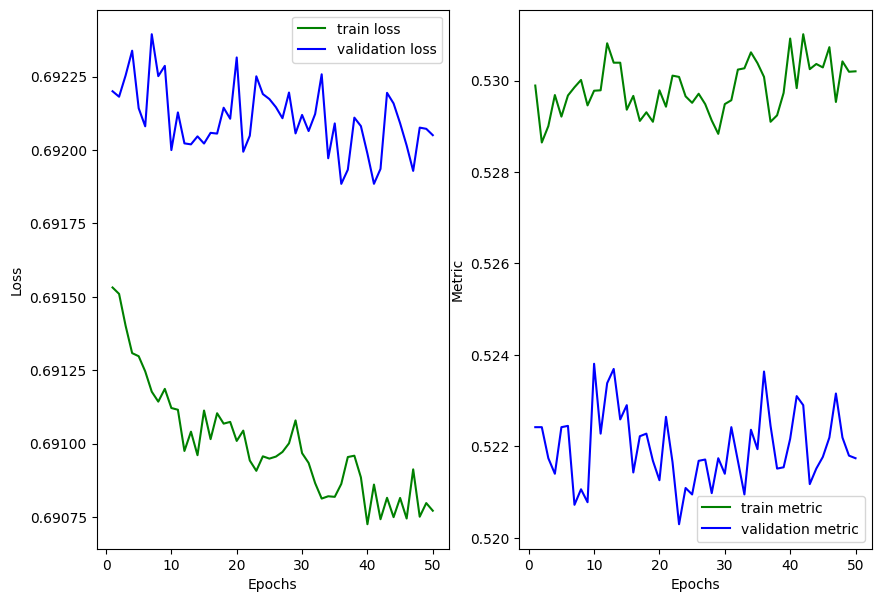

In [ ]:
plt.figure(figsize=(10, 7))
plt.subplot(1,2,1)
plt.plot(range(1,len(hist_loss)+1), hist_loss, color='green', linestyle='-', label='train loss')
plt.plot(range(1,len(hist_vloss)+1), hist_vloss, color='blue', linestyle='-', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(1,len(hist_metric)+1), hist_metric,  color='green', linestyle='-', label='train metric')
plt.plot(range(1,len(hist_vmetric)+1),hist_vmetric, color='blue', linestyle='-', label='validation metric')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()

In [ ]:
best_oracle = MLP_class(input_dim=16, output_dim=1, hidden_dim=128)
checkpoint = torch.load("best_oracle.pth", map_location=torch.device("cpu"), weights_only=False )
best_oracle.load_state_dict(checkpoint['model_state_dict'])
best_oracle.eval()

acc = Accuracy(task="binary")
criterion = nn.BCELoss()

loss = 0.
metric = 0.
counter = 0

with torch.no_grad():
  for xb, yb in test_dl:
    for i in range(angle_count):
        counter += 1
        x_rot = xb[:, i]
        y_rot = yb[:, i]
        y_rot = y_rot.unsqueeze(1)


        pred = best_oracle(x_rot)


        loss += criterion(pred, y_rot).item()
        metric += acc(pred, y_rot).item()

  loss /= counter
  metric /= (counter)

print('Test loss/accuracy oracle: ',loss, ' / ', metric)

Test loss/accuracy oracle:  0.690406141721684  /  0.5385246829710145


In [ ]:
class MLP(nn.Module):
  def __init__(self, input_dim, output_dim, hidden_dim):
    super(MLP, self).__init__()

    self.layer1 = nn.Linear(input_dim, hidden_dim)  #hidden layer
    self.layer2 = nn.Linear(hidden_dim, hidden_dim)
    self.layer3 = nn.Linear(hidden_dim, output_dim) #output layer

    self.relu = nn.ReLU() # relu function

  def forward(self, x):
    x = self.layer1(x)
    x = self.relu(x) # oppure x = F.relu(x)
    x = self.layer2(x)
    x = self.relu(x)
    out = self.layer3(x)

    return out

In [ ]:
generator = MLP(input_dim=16, output_dim=16, hidden_dim=128)
generator = generator.to(device)
print(generator)

from torchsummary import summary
if torch.cuda.is_available():
  summary(generator.cuda(), input_size=(1,16))
else:
  summary(generator, input_size=(1,16))

MLP(
  (layer1): Linear(in_features=16, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=16, bias=True)
  (relu): ReLU()
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]           2,176
              ReLU-2               [-1, 1, 128]               0
            Linear-3               [-1, 1, 128]          16,512
              ReLU-4               [-1, 1, 128]               0
            Linear-5                [-1, 1, 16]           2,064
Total params: 20,752
Trainable params: 20,752
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.08
Estimated Total Size (MB): 0.08
----------------------------------------------------------------


In [ ]:
def invariance_loss(y_inf, y, epsilon = 1e-3):
    """
    Compute invariance loss from equation (10) in the paper
    """

    # Calculate MSE scaled by epsilon^2
    loss = torch.mean((y_inf - y) ** 2) / (epsilon ** 2)

    return loss

In [ ]:
def normalization_loss(genx):
    """
    Compute normalization loss from equation (11) in the paper
    """

    # Compute norm of each transformed vector
    norms = torch.norm(genx, dim=1)

    # First term: ensure norm is close to 1
    norm_deviation = torch.mean((norms - 1.0) ** 2)

    # Second term: ensure consistent norm across samples
    mean_norm = torch.mean(norms)
    norm_variance = torch.mean((norms - mean_norm) ** 2)

    loss = norm_deviation + norm_variance

    return loss

In [ ]:
from torch import optim
lr = 0.001
opt = optim.Adam(generator.parameters(), lr=lr)

In [ ]:
import time

#save_best_model = SaveBestModel() #initialize checkpoint function
epsilon = 1e-3

epochs = 50
hist_loss = []
#hist_vloss = []

for epoch in range(epochs):
    t0 = time.time()

    # training step
    best_oracle.eval()
    train_loss = 0.
    vali_loss = 0.

    counter = 0
    for xb, yb in train_dl:
        for i in range(angle_count):
            counter += 1
            x_rot = xb[:, i]
            y_rot = yb[:, i].unsqueeze(1)

            x_rot = x_rot.to(device)
            y_rot = y_rot.to(device)

            genx = generator(x_rot)

            # Apply infinitesimal transformation
            x_inf = x_rot + epsilon * genx

            # Compute oracle output on transformed points
            y_inf = best_oracle(x_inf)

            inv_loss = invariance_loss(y_inf, y_rot, epsilon)

            norm_loss = normalization_loss(genx)

            loss = inv_loss + norm_loss

            train_loss += loss.item()


            # backpropagation
            opt.zero_grad()
            loss.backward()
            opt.step()


    train_loss /= counter
    """
    #counter = 0
    #oracle.eval()

    with torch.no_grad():
        for xb, yb in vali_dl:
            for i in range(angle_count):
                counter += 1
                x_rot = xb[:, i]
                y_rot = yb[:, i].unsqueeze(1)

                x_rot = x_rot.to(device)
                y_rot = y_rot.to(device)

                pred = oracle(x_rot)

                loss = criterion(pred, y_rot)

                vali_loss += loss.item()
                vali_metric += metric(pred, y_rot).item()


    vali_loss /= counter
    vali_metric /= counter
    """
    hist_loss.append(train_loss)
    #hist_vloss.append(vali_loss)

    #save_best_model(vali_loss, epoch, oracle, opt, criterion)

    current_lr = lr #lr_scheduler.get_last_lr()[0]
    elapsed_time = time.time()-t0
    print("epoch: %d, time(s): %.2f, tloss: %.3f, vloss: %.3f, lr: %1.2e"
          % (epoch+1, elapsed_time, train_loss, vali_loss, current_lr))

    # update learning rate schedule
    #lr_scheduler.step(vali_loss)

epoch: 1, time(s): 2.48, tloss: 248854.523, tmetric: 0.530, vloss: 0.000, vmetric: 0.522, lr: 1.00e-03
epoch: 2, time(s): 2.41, tloss: 248874.811, tmetric: 0.530, vloss: 0.000, vmetric: 0.522, lr: 1.00e-03
epoch: 3, time(s): 2.33, tloss: 248833.594, tmetric: 0.530, vloss: 0.000, vmetric: 0.522, lr: 1.00e-03
epoch: 4, time(s): 2.48, tloss: 248877.444, tmetric: 0.530, vloss: 0.000, vmetric: 0.522, lr: 1.00e-03
epoch: 5, time(s): 2.57, tloss: 248871.813, tmetric: 0.530, vloss: 0.000, vmetric: 0.522, lr: 1.00e-03
epoch: 6, time(s): 2.38, tloss: 248852.235, tmetric: 0.530, vloss: 0.000, vmetric: 0.522, lr: 1.00e-03
epoch: 7, time(s): 2.58, tloss: 248873.164, tmetric: 0.530, vloss: 0.000, vmetric: 0.522, lr: 1.00e-03
epoch: 8, time(s): 2.49, tloss: 248822.759, tmetric: 0.530, vloss: 0.000, vmetric: 0.522, lr: 1.00e-03
epoch: 9, time(s): 2.60, tloss: 248796.336, tmetric: 0.530, vloss: 0.000, vmetric: 0.522, lr: 1.00e-03
epoch: 10, time(s): 2.48, tloss: 248860.940, tmetric: 0.530, vloss: 0.000

In [ ]:

def visualize_latent_flow(generator, latent_vectors, decoder=None, steps=5, epsilon=0.01):
    with torch.no_grad():
        results = {
            'original_z': latent_vectors,
            'transformed_z': [],
            'decoded_images': [] if decoder else None
        }

        # For each starting point
        for z_start in latent_vectors:
            z_sequence = [z_start.clone()]
            z_current = z_start.clone()

            # Forward steps
            for _ in range(steps):
                delta_z = generator(z_current.unsqueeze(0)).squeeze(0)
                z_current = z_current + epsilon * delta_z
                z_sequence.append(z_current.clone())

            # Reset and do backward steps
            z_current = z_start.clone()
            for _ in range(steps):
                delta_z = generator(z_current.unsqueeze(0)).squeeze(0)
                z_current = z_current - epsilon * delta_z
                z_sequence.insert(0, z_current.clone())

            #results['transformed_z'].append(torch.stack(z_sequence))

            # Decode the transformed latent vectors if a decoder is provided
            if decoder and steps % 100 == 0:
                decoded_sequence = []
                for z in z_sequence:
                    decoded_img = decoder(z.unsqueeze(0))
                    decoded_sequence.append(decoded_img.squeeze(0))
                results['decoded_images'].append(torch.stack(decoded_sequence))

        return results

In [ ]:
model_vae = VAE(encoder, decoder)
checkpoint = torch.load('./vae_model.pth', map_location=torch.device("cpu"), weights_only=False )
model_vae.load_state_dict(checkpoint['model_state_dict'])
model_vae.to("cpu")
model_vae.eval()

VAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (fc1): Linear(in_features=4096, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=32, bias=True)
    (fc_mu): Linear(in_features=32, out_features=16, bias=True)
    (fc_logvar): Linear(in_features=32, out_features=16, bias=True)
    (activation): ReLU()
  )
  (decoder): Decoder(
    (conv1): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (conv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (conv3): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (fc1): Linear(in_features=64, out_features=4096, bias=True)
    (fc2): Linear(in_features=32, out_features=64

In [ ]:
results = visualize_latent_flow(generator, X_train_pt[1:2,0,], decoder=decoder, steps=, epsilon=0.01)

In [ ]:
image = results['decoded_images'][0][::100,]
image.shape

torch.Size([21, 1, 28, 28])

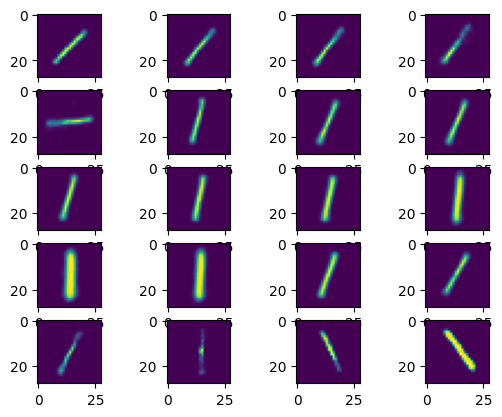

In [ ]:
for i in range(len(image[:-1])):
    plt.subplot(5,4,i+1)
    plt.imshow(image[i].reshape((28,28)))

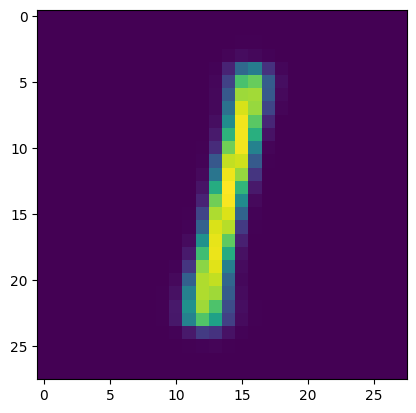

In [ ]:
original = decoder(X_train_pt[1][0].unsqueeze(0)).detach().numpy()
plt.imshow(original.reshape((28,28)))